In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

# WNBA

In [4]:
wnba = pd.read_csv("wnba.csv")
wnba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          143 non-null    object 
 1   Team          143 non-null    object 
 2   Pos           143 non-null    object 
 3   Height        143 non-null    int64  
 4   Weight        142 non-null    float64
 5   BMI           142 non-null    float64
 6   Birth_Place   143 non-null    object 
 7   Birthdate     143 non-null    object 
 8   Age           143 non-null    int64  
 9   College       143 non-null    object 
 10  Experience    143 non-null    object 
 11  Games Played  143 non-null    int64  
 12  MIN           143 non-null    int64  
 13  FGM           143 non-null    int64  
 14  FGA           143 non-null    int64  
 15  FG%           143 non-null    float64
 16  15:00         143 non-null    int64  
 17  3PA           143 non-null    int64  
 18  3P%           143 non-null    

In [4]:
wnba.shape

(143, 32)

## Sampling

In [5]:
games_played = wnba['Games Played']
parameter = games_played.max()
parameter

32

In [6]:
sample = games_played.sample(30, random_state=1)
statistic = sample.max()
statistic

30

In [7]:
sampling_error = parameter - statistic

### Random Sampling

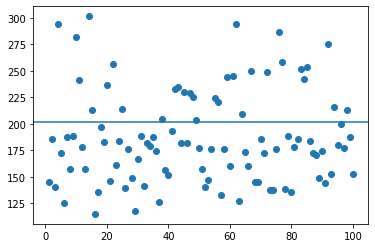

In [8]:
avg_points = []
for i in range(100):
    sample = wnba.PTS.sample(10, random_state=i)
    mean = sample.mean()
    avg_points.append(mean)

plt.scatter(x=range(1, 101), y=avg_points)
plt.axhline(wnba.PTS.mean())

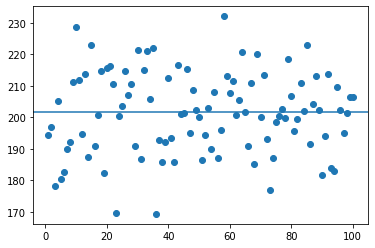

In [9]:
avg_points = []
for i in range(100):
    sample = wnba.PTS.sample(80, random_state=i)
    mean = sample.mean()
    avg_points.append(mean)

plt.scatter(x=range(1, 101), y=avg_points)
plt.axhline(wnba.PTS.mean())

In [10]:
wnba.Pos.value_counts()

G      60
F      33
C      25
G/F    13
F/C    12
Name: Pos, dtype: int64

### Stratified sampling

In [5]:
wnba['points_per_game'] = wnba.PTS / wnba['Games Played']
positions = wnba.Pos.unique()
stratas = {}
for position in positions:
    stratas[position] = wnba[wnba.Pos == position]

In [6]:
results = {}
for strata in stratas.items():
    position = strata[0]
    sample = strata[1].sample(10, random_state=0)
    mean_ppg = sample.points_per_game.mean()
    results[position] = mean_ppg

In [8]:
# Position with most points
max(results, key=results.get)

'C'

In [11]:
wnba['Games Played'].value_counts(bins = 3, normalize = True) * 100

(22.0, 32.0]     72.727273
(12.0, 22.0]     18.181818
(1.969, 12.0]     9.090909
Name: Games Played, dtype: float64

Number of games played has an effect on the total number of points scored per season. Sampling could be biased depending on the number of picks from each bracket shown above, especially with small samples. Stratified sampling can solve this issue, as long as the relative proportions are respected.

In [30]:
# Strata
s1 =  wnba[wnba['Games Played'] <= 12].PTS
s2 =  wnba[(wnba['Games Played'] > 12) & (wnba['Games Played'] <= 22)].PTS
s3 =  wnba[wnba['Games Played'] > 22].PTS

In [31]:
results = []
for run in range(100):
    # Sample strata proportionally
    samp_s1 = s1.sample(1, random_state=run)
    samp_s2 = s2.sample(2, random_state=run)
    samp_s3 = s3.sample(7, random_state=run)
    final_sample = pd.concat([samp_s1, samp_s2, samp_s3])
    # Save mean of sample
    results.append(final_sample.mean())

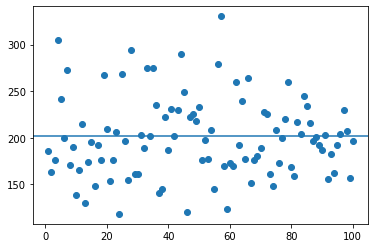

In [33]:
# Sample means
plt.scatter(x=range(1,101), y=results)
plt.axhline(np.mean(wnba.PTS))

This method appears to not work much better than random sampling. A better approach would be use strata based on minutes played per season since 2 minutes of play would be count as a full play.
Guidlines:  
1. Minimize variablility within each startum   
    The closer the number of scored points is for each player in a startum, the better.   
2. Maximize variability between strata   
    Low variability might require higer granularity   
3. The staratification criterion should be strongly correlated with the measurement   
    Minutes played should correlate with points scored

In [12]:
metrics_per_n_bins = {}
# Optimize for number of bins
for n_bins in range(2,16):
    bin_intervals = wnba['MIN'].value_counts(bins=n_bins).index
    bins = []
    for i in range(n_bins):
        # Select number of points for each bin
        bin_mask = [True if MIN in bin_intervals[i] else False for MIN in wnba.MIN]
        points_in_bin = wnba[bin_mask].PTS
        bins.append(points_in_bin)
    # Bin means
    bin_means = []
    # Variation within bins
    within_var = []
    for bin in bins:
        within_var.append(np.std(bin))
        bin_means.append(np.mean(bin))
    # Variation between bins
    between_var = np.std(bin_means)
    # Varriation metric
    result = between_var/np.mean(within_var)
    metrics_per_n_bins[n_bins] = result
    print(n_bins)
    print('Within:', within_var)
    print('Between:', between_var)

2
Within: [63.42057173282908, 120.66067864006186]
Between: 119.46739130434781
3
Within: [70.49290460748513, 32.404989327776875, 113.60232565868417]
Between: 133.03234472051574
4
Within: [30.740354178180834, 75.77555185271109, 53.04610516669816, 104.40358889904121]
Between: 137.32232014323858
5
Within: [33.618029017180646, 81.36545761699098, 22.914564995690753, 100.50814770505941, 59.40553509564576]
Between: 137.5080233859186
6
Within: [88.17197001483123, 48.12245536191158, 21.35834717581958, 68.12334350687402, 21.446502729788907, 105.52433748888991]
Between: 144.7089961696461
7
Within: [17.142041885376432, 80.68077542779004, 64.5904942469861, 19.546328476624446, 50.08209327176724, 108.64786870896272, 30.985883882826386]
Between: 142.7008603577812
8
Within: [15.165750888103101, 76.8116346062519, 78.8698215635271, 32.03031935564632, 22.323975040115403, 55.78554780362025, 50.95766472033427, 112.64685352670732]
Between: 143.15169799320705
9
Within: [89.13708263755208, 68.35652827966582, 13

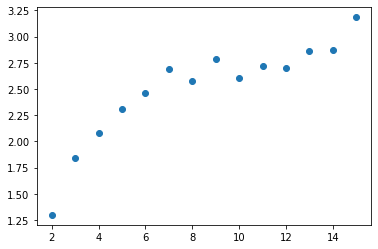

In [73]:
plt.scatter(metrics_per_n_bins.keys(), metrics_per_n_bins.values())

7 MIN bins appear to be optimal for minimizing within variation and maximizing between variation.

## Cluster sampling
-> pick random sources for data from clusters (eg. website of sport teams) to reduce overall collection process.

In [89]:
# Random team selection
team_clusters = pd.Series(wnba.Team.unique()).sample(4, random_state=0)
team_clusters

6     PHO
11    IND
4     MIN
10    ATL
dtype: object

In [109]:
# Cluster data
team_mask = [True if team in team_clusters.values else False for team in wnba.Team]
cluster_data = wnba[team_mask]
attributes_of_intest = ['Height', 'Age', 'BMI', 'PTS']
# Actual data
cluster_means = cluster_data[attributes_of_intest].mean()
actual_means = wnba[attributes_of_intest].mean()

In [114]:
# Samping errors
errors = actual_means - cluster_means
sampling_error_height = errors[0]
sampling_error_age = errors[1]
sampling_error_BMI = errors[2]
sampling_error_points = errors[3]

In [115]:
sampling_error_height

-0.06400121617511445

## Percentiles

In [18]:
wnba.Age.quantile(0.19, interpolation='lower')

23

In [21]:
from scipy.stats import percentileofscore
# Percentage below age 23
print(percentileofscore(a = wnba.Age, score = 23, kind = 'weak')) # weak returns returns percentile for values upto and including "score"

18.88111888111888


In [22]:
# Percentage above age 30
print(100 - percentileofscore(wnba['Age'], 29, kind = 'weak'))

26.573426573426573


In [23]:
# Additional percentiles for .describe()
print(wnba['Age'].describe(percentiles = [.1, .15, .33, .5, .592, .85, .9]).iloc[3:])

min      21.0
10%      23.0
15%      23.0
33%      25.0
50%      27.0
59.2%    28.0
85%      31.0
90%      32.0
max      36.0
Name: Age, dtype: float64
